In [12]:
import torch
import numpy as np

In [95]:
from dataset import PhysObsDataset, DEFAULT_TRANSFORM
from model import AcroModel
from tqdm import tqdm
import json
import PIL

dataset = PhysObsDataset("images")

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model = AcroModel(dinov2_vits14)
model.load_state_dict(torch.load("model.pth"))

with open('ego_objects_challenge_train.json', 'r') as file:
    json_data = json.load(file)

object_dict = {}

for fname in tqdm(dataset.filenames):
    train_image_id = dataset.fname_to_train_id[fname]
    image_entry = next((image for image in json_data["images"] if image["id"] == train_image_id), None)

    main_category = image_entry["main_category"]

    if main_category not in object_dict:
        object_dict[main_category] = [fname]
    else:
        object_dict[main_category].append(fname)


Using cache found in /home/shrey/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 2769/2769 [00:03<00:00, 777.82it/s] 


In [96]:

model = model.eval()
model.to_device("cuda")

objects = sorted(list(object_dict.keys()), key=lambda x: len(object_dict[x]), reverse=True)[:20]
feature_list = []
for object in tqdm(objects):
    
    object_images = [DEFAULT_TRANSFORM(PIL.Image.open(f"images/{image}")) for image in object_dict[object]]
    object_images = torch.stack(object_images).to("cuda")

    features = model.encode(object_images)
    feature_list.append(features.detach().cpu())

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


In [85]:
print([len(object_dict[object]) for object in objects])

[56, 41, 36, 35, 35, 35, 35, 34, 33, 32, 32, 31, 31, 31, 30, 29, 29, 28, 28, 27]


In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(all_features)

PCA(n_components=2)

In [18]:
objects_pca = []
for object in objects:
    objects_pca.append(pca.transform(torch.load("features/" + object + ".pth").detach().numpy()))

In [66]:
from scipy import spatial 

dists = np.zeros((len(objects), len(objects)))

for i, object1 in enumerate(objects):
    obj_dists = np.zeros(len(objects))
    for feature1 in feature_list[i]:
        feat_dists = np.zeros(len(objects))
        for j,object2 in enumerate(objects):
            for feature2 in feature_list[j]:
                if feature1 is not feature2:
                    feat_dists[j] = spatial.distance.cosine(feature1, feature2)
        obj_dists += feat_dists
    obj_dists /= len(features[i])
    dists[i] = obj_dists
                


<Axes: >

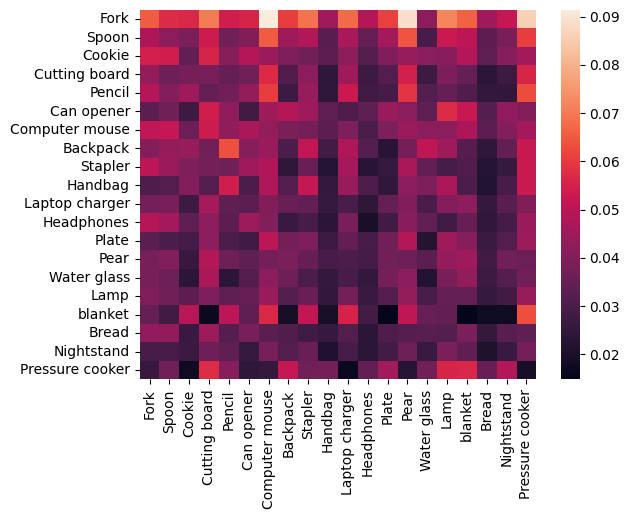

In [67]:
import seaborn as sns

sns.heatmap(dists, xticklabels=objects, yticklabels=objects)

In [86]:
class ObjectClf(torch.nn.Module):
    def __init__(self, n_objects):
        super().__init__()
        self.fc = torch.nn.Linear(512, n_objects)
    
    def forward(self, x):
        return self.fc(x)

In [118]:
class ObjDataset(torch.utils.data.Dataset):
    def __init__(self, objects, feature_list):
        self.objects = objects
        self.feature_list = feature_list

        self.object2class = {object: i for i, object in enumerate(objects)}
        self.labels = torch.cat([torch.tensor([self.object2class[object]]*len(feature_list[i])) for i, object in enumerate(objects)], dim=0)
        self.features = torch.cat(feature_list)
        

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx, :], self.labels[idx]

In [133]:
dataset = ObjDataset(objects, feature_list)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [134]:
model = ObjectClf(len(objects))

In [135]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = model.to("cuda")
train_losses = []
val_losses = []

for epoch in tqdm(range(100)):
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        output = model(features.cuda())
        loss = criterion(output.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    with torch.no_grad():
        val_loss = 0.0
        for features, labels in val_loader:
            output = model(features.cuda())
            loss = criterion(output.cuda(), labels.cuda())
            val_loss += loss.item()
        val_loss /= len(val_loader)

    train_losses.append(running_loss)
    val_losses.append(val_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 114.47it/s]


In [136]:
len(labels)

3

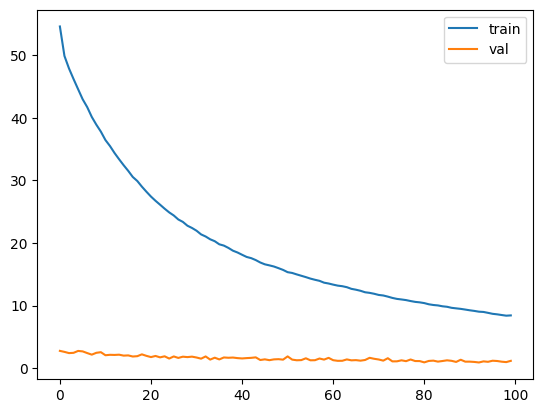

In [137]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

In [142]:
# test
test_dataset = ObjDataset(objects, feature_list)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

import torch
from sklearn.metrics import confusion_matrix

# Assuming your model is 'model' and dataloader is 'test_dataloader'
model.eval()  # Ensure the model is in evaluation mode

# These will store the true and predicted labels
true_labels = []
pred_labels = []

# Use no_grad to not store computations from forward pass, since we don't need backpropagation during model evaluation
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)  # Move input tensors to the device
        classes = classes.to(device)  # Move labels to the device
        outputs = model(inputs)  # Get model output
        _, preds = torch.max(outputs, 1)  # Preds is the index of the max value, which would be your model's chosen class

        true_labels.extend(classes.cpu().numpy())  # Extend the true labels list
        pred_labels.extend(preds.cpu().numpy())  # Extend the predicted labels list

# Now using sklearn to create the confusion matrix
matrix = confusion_matrix(true_labels, pred_labels)
print(matrix)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [139]:
accuracy

0.9131736526946108